**Autores**: 
1. Caio Fernandes - 170138798
2. Lucas Dutras - 170050939

Este projeto tem como objetivo utilizar `jupyter notebook` e a biblioteca `pandas` juntamente com o conteúdo de **Percorrer Grafos** para indicar qual o caminho mais rápido para chegar em um país a partir de um país inicial.

Utilizaremos para isso dois datasets disponibilizados no Kaggle com informações sobre [Países e Fronteiras](https://www.kaggle.com/resheto/country-borders) e [Países e Continentes](https://www.kaggle.com/tomvebrcz/countriesandcontinents).

In [2]:
import pandas as pd
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
df_border = pd.read_csv('./data/border_info.csv')
df_continents = pd.read_csv('./data/countries.csv')
df_border = df_border.sort_values(by=['country_name'])
df_continents = df_continents.sort_values(by=['Country'])

## Avaliação do Dado

In [4]:
df_border.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 728 entries, 9 to 727
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0           728 non-null    int64 
 1   country_name         728 non-null    object
 2   country_border_name  642 non-null    object
dtypes: int64(1), object(2)
memory usage: 22.8+ KB


## Limpando o dado 

Removendo países sem fronteira

In [5]:
is_NaN = df_border.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df_border[row_has_NaN]
rows_with_NaN

,Unnamed: 0,country_name,country_border_name
41,41,Aland Islands,NaN
30,30,American Samoa,NaN
11,11,Anguilla,NaN
24,24,Antarctica,NaN
10,10,Antigua and Barbuda,NaN
...,...,...,...
684,684,United States Minor Outlying Islands,NaN
704,704,Vanuatu,NaN
699,699,Virgin Islands (British),NaN
700,700,Virgin Islands (U.S.),NaN


Temos 86 países sem fronteiras no dado

Removendo-os:

In [6]:
df_border = df_border.drop(rows_with_NaN.index)

Notamos que, neste dado em questão, temos 727 valores.
Tal dado também apresenta duas colunas, uma `country_name` representando o país e outra chamada `coutry_border_name` que representa um fronteira daquele país.

In [7]:
df_border.head()

,Unnamed: 0,country_name,country_border_name
9,9,Afghanistan,Uzbekistan
4,4,Afghanistan,China
5,5,Afghanistan,Iran
6,6,Afghanistan,Pakistan
7,7,Afghanistan,Tajikistan


Logo percebemos um problema, a maneira como o dado está organizado, nos trás informações duplicadas sobre países.
Para corrigir este problema, faremos, para cada país, uma coluna com uma lista de todas as fronteiras.
Com isso, teremos na estrutura do `DataFrame`, países únicos na coluna `country_name` com suas fronteiras listada na coluna `border_list`.

In [8]:
k = df_border.groupby('country_name')['country_border_name'].apply(lambda x: list(x))
df_border = df_border.drop(columns=['country_border_name'])
df_border = df_border.drop_duplicates(subset=['country_name'])
aux = [item for item in k]
df_border['border_list'] = aux

Após transformarmos o dado inicial em menos linhas, é necessária a reindexação do dataframe.

In [9]:
df_border = df_border.reset_index()
df_border = df_border.drop(columns=['Unnamed: 0', 'index'])

## Cruzando as duas fontes de dados

Agora, iremos cruzar os dados do dataset de fronteiras juntamente com o dataset de continentes, para, posteriormente, montarmos vários grafos, sendo cada um deles representante de um continente.

In [10]:
df_continents['Region'] = df_continents['Region'].replace('LATIN', 'AMERICA')
df_continents['Region'] = df_continents['Region'].replace('NORTHERN_AMERICA', 'AMERICA')
df_continents['Region'] = df_continents['Region'].replace('NEAR_EAST', 'ASIA')
border_l = df_border['country_name'].tolist()
cont_l = df_continents['Country'].tolist()
diff = []
for item in cont_l:
    if item in border_l:
        continent = df_continents.loc[df_continents['Country'] == item]
        continent = continent['Region']
        for elem in continent.iteritems():
            df_border.loc[df_border['country_name'] == item, 'continent'] = elem[1]

Porém, como os dados provém de fontes diferentes e existe a possibilidade de haver nomeações diferentes para cada país, logo um conjunto de dados ficará sem a devida informação de continente.

In [11]:
is_NaN = df_border.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df_border[row_has_NaN]
rows_with_NaN

,country_name,border_list,continent
16,Bosnia and Herzegovina,"[Croatia, Serbia, Montenegro]",NaN
26,Central African Republic,"[Cameroon, Chad, Congo (Kinshasa), Congo (the ...",NaN
31,Congo (Kinshasa),"[Cameroon, Central African Republic, Congo (th...",NaN
32,Congo (the Democratic Republic of the),"[Burundi, Angola, Tanzania, Rwanda, South Suda...",NaN
34,Cote d'Ivoire,"[Burkina Faso, Ghana, Guinea, Liberia, Mali]",NaN
36,Czechia,"[Austria, Germany, Poland, Slovakia]",NaN
46,Eswatini,"[Mozambique, South Africa]",NaN
63,Holy See,[Italy],NaN
77,Korea (Democratic People's Republic of),"[Russia, Korea, South, China]",NaN
78,"Korea, South",[Korea (Democratic People's Republic of)],NaN


Identificando os países que não estavam presentes com a mesma notação, agrupamos em grupos por continente e foi feita a atribuição devida para cada um dos sobressalentes.

In [12]:
eu = ['Bosnia and Herzegovina', 'Czechia', 'Holy See', 'Montenegro', 'North Macedonia']
asia = ['Korea (Democratic People\'s Republic of)', 'Korea, South', 'Macao', 'Myanmar', 'Palestine, State of', 'Timor-Leste']
america = ['Saint Martin (French part)', 'Sint Maarten (Dutch part)', 'US']
africa = ['Central African Republic', 'Congo (Kinshasa)', 'Congo (the Democratic Republic of the)', 'Cote d\'Ivoire', 'Eswatini', 'South Africa', 'South Sudan']
for country in eu:
    df_border.loc[df_border['country_name'] == country, 'continent'] = 'EUROPE'
for country in asia:
    df_border.loc[df_border['country_name'] == country, 'continent'] = 'ASIA'
for country in america:
    df_border.loc[df_border['country_name'] == country, 'continent'] = 'AMERICA'
for country in africa:
    df_border.loc[df_border['country_name'] == country, 'continent'] = 'AFRICA'

In [13]:
df_continents['Region'].value_counts()

AFRICA     57
EUROPE     50
AMERICA    50
ASIA       49
OCEANIA    21
Name: Region, dtype: int64

# Implementando Lista de Adjacência para formar a rede de Grafo

In [14]:
graph = defaultdict(list)
for item in df_border.country_name.unique():
    graph[item] = df_border.border_list[df_border.country_name==item].item()

In [15]:
graph

defaultdict(list,
            {'Afghanistan': ['Uzbekistan',
              'China',
              'Iran',
              'Pakistan',
              'Tajikistan',
              'Turkmenistan'],
             'Albania': ['Serbia', 'North Macedonia', 'Montenegro', 'Greece'],
             'Algeria': ['Mali',
              'Tunisia',
              'Niger',
              'Libya',
              'Morocco',
              'Western Sahara',
              'Mauritania'],
             'Andorra': ['France', 'Spain'],
             'Angola': ['Congo (Kinshasa)',
              'Congo (the Democratic Republic of the)',
              'Namibia',
              'Zambia'],
             'Argentina': ['Uruguay',
              'Brazil',
              'Bolivia',
              'Chile',
              'Paraguay'],
             'Armenia': ['Georgia', 'Iran', 'Turkey', 'Azerbaijan'],
             'Austria': ['Slovenia',
              'Czechia',
              'Germany',
              'Hungary',
              'Liechtenstei

# Aplicando busca em largura - Breadth First Search (BFS)

In [16]:
visited = defaultdict()
def backtrace(parent, start, end):
    path = [end]
    while path[-1] != start:
        path.append(parent[path[-1]])
    path.reverse()
    return path

def bfs(graph, start, end):
    parent = {}
    queue = []
    visited[start] = True
    queue.append(start)
    while queue:
        node = queue.pop(0)
        if node == end:
            return backtrace(parent, start, end)
        for adjacent in graph.get(node, []):
                if adjacent not in visited.keys():
                    if node not in queue :
                        parent[adjacent] = node # <<<<< record its parent 
                        queue.append(adjacent)
                        visited[adjacent] = True

country_path = bfs(graph, 'Colombia', 'US')

## Visualização da árvore resultante da busca em largura

In [17]:
resultant_tree = nx.Graph()
i, j = 0, 1
while j < len(country_path):
    resultant_tree.add_edge(country_path[i], country_path[j])
    i += 1
    j += 1

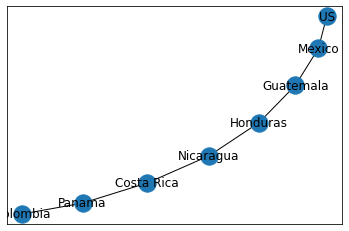

In [27]:
nx.draw_networkx(resultant_tree) 